In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [2]:
mnist_transform=transforms.Compose([
                              transforms.Resize((28,28)),
                              transforms.ToTensor(), # first, convert image to PyTorch (float) tensor
                              transforms.Normalize((0.5,), (0.5,)) # normalize inputs, x' = (x-u)/std, x'=[-1, 1] 
                              ])     

train_dataset = datasets.MNIST(root='./mnist_data', 
                                  train=True, 
                                  download=True, 
                                  transform=mnist_transform)

# validation or test 
validation_dataset = datasets.MNIST(root='./mnist_data', 
                                  train=False, 
                                  download=True, 
                                  transform=mnist_transform)

print(train_dataset)
print(validation_dataset)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True) 
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False) 
# shuffle training data before each epoch to avoid local min


Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./mnist_data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


# contruct model architecture

In [6]:
class NN_MNIST(nn.Module):
  def __init__(self, NN_in, H1, H2, NN_out):
    super().__init__()
    self.linear1 = nn.Linear(NN_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, NN_out)

  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x) # activation not needed for multi-class classification task
    return x

# make model instance 


In [7]:
torch.manual_seed(1)
model = NN_MNIST(784, 128, 64, 10)
model

NN_MNIST(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

# optimizer 

In [8]:
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)#momentum=0.5
criterion = nn.CrossEntropyLoss() # Softmax (nn.LogSoftmax()) + CrossEntropy (nn.NLLLoss())

In [9]:
epochs = 30
running_loss_history = []
running_corrects_history = []

val_running_loss_history = []
val_running_corrects_history = []


for eno in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0
  
  val_running_loss = 0.0
  val_running_corrects = 0.0

  # a batch of 100 images x 600 batches -> 60,000 for a single epoch 
  for inputs, labels in train_loader:     
    # input [100(batch size), 1(channel), 28(width), 28(height)] =>     
    inputs = inputs.view(inputs.shape[0], -1) # [100, 784]
    outputs = model(inputs) # logits (scores)
    loss = criterion(outputs, labels) # outputs [100, 10], labels [100]
    #print(outputs)
    #print(labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #max function output(max, max_indices)
    _, pred_idx = torch.max(outputs, 1) # 2nd argument - the dim to reduce    

    running_loss += loss.item() # loss per batch 
    running_corrects += torch.sum(pred_idx == labels.data)
  else:
    with torch.no_grad(): 
     for val_inputs, val_labels in validation_loader:     
        # input [100(batch size), 1(channel), 28(width), 28(height)] =>     
        val_inputs = val_inputs.view(val_inputs.shape[0], -1) # [100, 784]
        val_outputs = model(val_inputs) # logits (scores)
        val_loss = criterion(val_outputs, val_labels) # outputs [100, 10], labels [100]
        
        _, val_preds = torch.max(val_outputs, 1) # 2nd argument - the dim to reduce    

        val_running_loss += val_loss.item() # loss per batch 
        val_running_corrects += torch.sum(val_preds == val_labels.data)
    
    
    epoch_loss = running_loss/len(train_loader) 
    running_loss_history.append(epoch_loss)
    epoch_acc = (running_corrects.float()/inputs.shape[0]*100)/len(train_loader) 
    running_corrects_history.append(epoch_acc)
    print('--------------- epoch: ', (eno+1), '---------------')
    print('training loss: {:.4f}, accuracy {:.4f}'.format(epoch_loss, epoch_acc.item()))   
    
    val_epoch_loss = val_running_loss/len(validation_loader) 
    val_running_loss_history.append(val_epoch_loss)
    val_epoch_acc = (val_running_corrects.float()/val_inputs.shape[0]*100)/len(validation_loader) 
    val_running_corrects_history.append(val_epoch_acc)
    print('--------------- epoch: ', (eno+1), '---------------')
    print('validation loss: {:.4f}, validation accuracy {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))   

--------------- epoch:  1 ---------------
training loss: 1.3136, accuracy 62.8933
--------------- epoch:  1 ---------------
validation loss: 0.5556, validation accuracy 85.1700
--------------- epoch:  2 ---------------
training loss: 0.4651, accuracy 87.0350
--------------- epoch:  2 ---------------
validation loss: 0.3840, validation accuracy 89.2400
--------------- epoch:  3 ---------------
training loss: 0.3731, accuracy 89.3417
--------------- epoch:  3 ---------------
validation loss: 0.3318, validation accuracy 90.4700
--------------- epoch:  4 ---------------
training loss: 0.3346, accuracy 90.3600
--------------- epoch:  4 ---------------
validation loss: 0.3096, validation accuracy 91.1400
--------------- epoch:  5 ---------------
training loss: 0.3094, accuracy 91.0183
--------------- epoch:  5 ---------------
validation loss: 0.2918, validation accuracy 91.5400
--------------- epoch:  6 ---------------
training loss: 0.2908, accuracy 91.5383
--------------- epoch:  6 -------

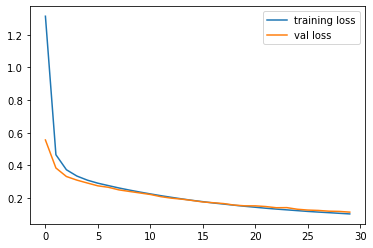

In [10]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='val loss')
plt.legend()

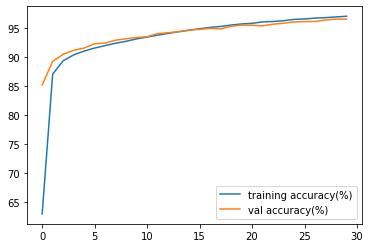

In [11]:
plt.plot(running_corrects_history, label='training accuracy(%)')
plt.plot(val_running_corrects_history, label='val accuracy(%)')
plt.legend()

In [13]:
def fConvertImg(tensor):
  # [1, 28, 28] channel x width x height
  image = tensor.clone().detach().numpy() 
  image = image.transpose(1, 2, 0) # [28, 28, 1] , print(image.shape) > (28, 28, 1)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))  # de-nomalization   x'=x-u/sigma > x = x'*sigma + u 
  image = image.clip(0, 1)  
  return image

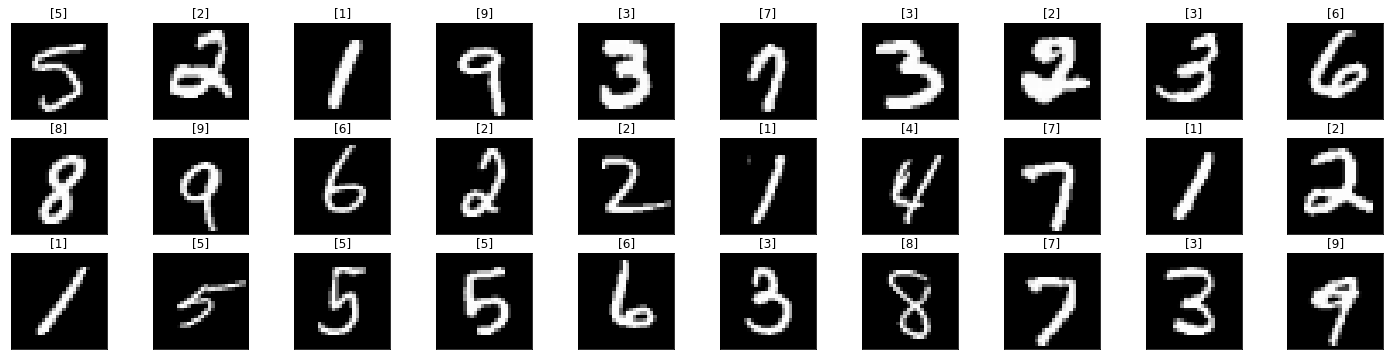

In [29]:
dataiter = iter(train_loader) # create iteration for one element at a time
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 6)) #width, height tuple

for idx in np.arange(30):
  #ax = fig.add_subplot(3, 10, idx+1, xticks=[], yticks=[])  
  axes = fig.add_subplot(3, 10, idx+1, xticks=[], yticks=[]) 
  plt.imshow(fConvertImg(images[idx]))
  axes.set_title([labels[idx].item()])
  

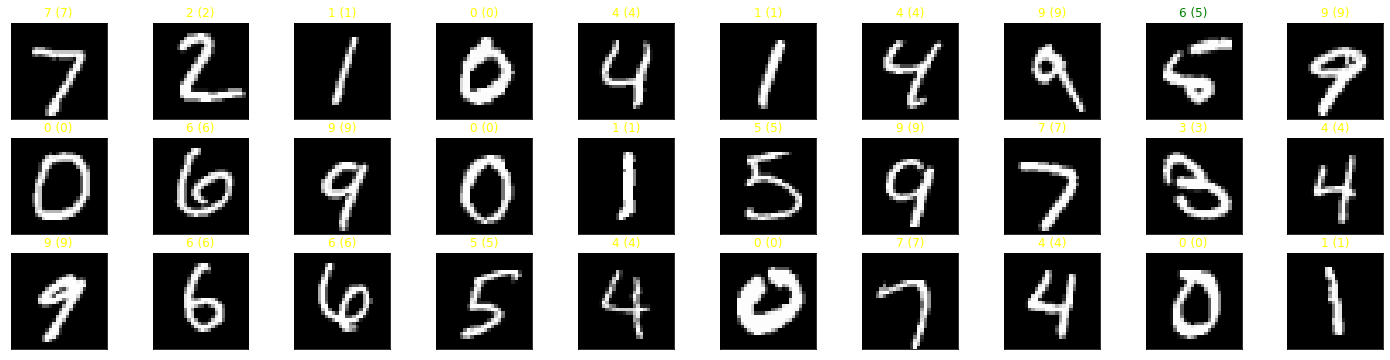

In [16]:
dataiter = iter(validation_loader) # create iteration for one element at a time
images, labels = dataiter.next()
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 6)) #width, height tuple

for idx in np.arange(30):
  #ax = fig.add_subplot(3, 10, idx+1, xticks=[], yticks=[])  
  axes = fig.add_subplot(3, 10, idx+1, xticks=[], yticks=[]) 
  plt.imshow(fConvertImg(images[idx]))
  axes.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("yellow" if preds[idx]==labels[idx] else "green"))
  #axes.set_title([labels[idx].item()])